# Find periodic variables in ComCam data

# NOTES

- Use magnitude columns
- Try diaObjects
- S/N > 10
- VSX cross-match?

## Installation

In [1]:
# %pip install lsdb dask nested-dask astropy light-curve

In [1]:
import lsdb
lsdb.__version__

INFO:numexpr.utils:Note: detected 128 virtual cores but NumExpr set to maximum of 64, check "NUMEXPR_MAX_THREADS" environment variable.
INFO:numexpr.utils:Note: NumExpr detected 128 cores but "NUMEXPR_MAX_THREADS" not set, so enforcing safe limit of 8.
INFO:numexpr.utils:NumExpr defaulting to 8 threads.


'0.4.5.dev12+g93c26b7'

In [2]:
import pandas as pd
pd.__version__

'2.2.3'

In [3]:
from pathlib import Path

release = 'w_2025_04'
hats_path = Path("/sdf/data/rubin/shared/lsdb_commissioning/DASH/") / release / "hats"
# list dir
print(list(map(str, hats_path.iterdir())))

comcam_obj = hats_path / "object"
comcam_src = hats_path / "forcedSource"

['/sdf/data/rubin/shared/lsdb_commissioning/DASH/w_2025_04/hats/diaSource', '/sdf/data/rubin/shared/lsdb_commissioning/DASH/w_2025_04/hats/source', '/sdf/data/rubin/shared/lsdb_commissioning/DASH/w_2025_04/hats/diaForcedSource', '/sdf/data/rubin/shared/lsdb_commissioning/DASH/w_2025_04/hats/object', '/sdf/data/rubin/shared/lsdb_commissioning/DASH/w_2025_04/hats/diaObject', '/sdf/data/rubin/shared/lsdb_commissioning/DASH/w_2025_04/hats/forcedSource']


## Start Dask client

In [4]:
from dask.distributed import Client

# Start with a small client
client = Client(n_workers=24, memory_limit="16GB", threads_per_worker=1)
client

INFO:distributed.http.proxy:To route to workers diagnostics web server please install jupyter-server-proxy: python -m pip install jupyter-server-proxy
INFO:distributed.scheduler:State start
INFO:distributed.diskutils:Found stale lock file and directory '/lscratch/ncaplar/dask-scratch-space/scheduler-dubrupdi', purging
INFO:distributed.diskutils:Found stale lock file and directory '/lscratch/ncaplar/dask-scratch-space/scheduler-4mofrk11', purging
INFO:distributed.scheduler:  Scheduler at:      tcp://127.0.0.1:7459
INFO:distributed.scheduler:  dashboard at:  http://127.0.0.1:8787/status
INFO:distributed.scheduler:Registering Worker plugin shuffle
INFO:distributed.nanny:        Start Nanny at: 'tcp://127.0.0.1:4967'
INFO:distributed.nanny:        Start Nanny at: 'tcp://127.0.0.1:28557'
INFO:distributed.nanny:        Start Nanny at: 'tcp://127.0.0.1:6911'
INFO:distributed.nanny:        Start Nanny at: 'tcp://127.0.0.1:7285'
INFO:distributed.nanny:        Start Nanny at: 'tcp://127.0.0.1:80

Connection method: Cluster object,Cluster type: distributed.LocalCluster
Dashboard: http://127.0.0.1:8787/status,
Dashboard: http://127.0.0.1:8787/status,Workers: 24
Total threads: 24,Total memory: 357.63 GiB
Status: running,Using processes: True
Comm: tcp://127.0.0.1:7459,Workers: 24
Dashboard: http://127.0.0.1:8787/status,Total threads: 24
Started: Just now,Total memory: 357.63 GiB
Comm: tcp://127.0.0.1:26087,Total threads: 1
Dashboard: http://127.0.0.1:7507/status,Memory: 14.90 GiB
Nanny: tcp://127.0.0.1:4967,


## Loading & Nesting Forced Sources

In [5]:
# Load the Forced Source + MJD Table
from lsdb import read_hats


obj = read_hats(
    comcam_obj,
    columns=["objectId", "coord_ra", "coord_dec"],
)
src_flat = read_hats(
    comcam_src,
    columns=[
        "objectId", 
        # "coord_ra", "coord_dec",
        "band",
        "midpointMJDTai",
        "psfFlux", "psfFluxErr", "psfFlux_flag",
        "psfMag", "psfMagErr",
        "pixelFlags_suspect", "pixelFlags_saturated", "pixelFlags_cr", "pixelFlags_bad",
        "forcedSourceId",
        "detector",
        "visit",
    ],
)
src_nested = obj.join_nested(
    src_flat,
    nested_column_name="lc",
    left_on="objectId",
    right_on="objectId",
)
src_nested

/sdf/home/n/ncaplar/.local/lib/python3.11/site-packages/lsdb/dask/join_catalog_data.py:332: RuntimeWarning: Right catalog does not have a margin cache. Results may be incomplete and/or inaccurate.
  warnings.warn(


,objectId,coord_ra,coord_dec,lc
npartitions=161,,,,
"Order: 5, Pixel: 32",int64[pyarrow],double[pyarrow],double[pyarrow],"nested<band: [string], midpointMJDTai: [double..."
"Order: 7, Pixel: 544",...,...,...,...
...,...,...,...,...
"Order: 6, Pixel: 35970",...,...,...,...
"Order: 6, Pixel: 35971",...,...,...,...


## Filter out "bad" detections and select light curves with enough observations

In [6]:
# Pre-Processing

# Use just r-band data
# src_nested = src_nested.query("lc.band == 'r'").dropna(subset="lc")

# S/N >= 3
src_nested = src_nested.dropna(subset="lc.psfFlux").query(
    # "lc.psfFlux / lc.psfFluxErr >= 5.0"
    "lc.psfFlux > 5000 and lc.psfFluxErr > 0"
    " and ~lc.psfFlux_flag"
    " and ~lc.pixelFlags_suspect"
    " and ~lc.pixelFlags_saturated"
    " and ~lc.pixelFlags_cr"
    " and ~lc.pixelFlags_bad"
).dropna(subset="lc")

MIN_NOBS = 50
MIN_NOBS_BAND = 30

# Count the length of the lightcurves, and add a length filter
# from nested_dask.utils import count_nested
# src_nested = count_nested(src_nested, "lc", join=True).query(f"n_lc >= {MIN_NOBS}")
import numpy as np
src_nested = src_nested.reduce(
    lambda x: {"n_lc": np.size(x)},
    "lc.psfFlux",
    meta={"n_lc": int},
    append_columns=True,
).query(f"n_lc >= {MIN_NOBS}")

In [7]:
# Non-lazy computation
len(src_nested._ddf)

114416

## Running Lomb-Scargle
Use light-curve package or astropy

In [24]:
import light_curve as licu
import numpy as np
from astropy.timeseries import BoxLeastSquares, LombScargleMultiband

periodogram_extractor = licu.Periodogram(
    peaks=10,
    nyquist='average',
    # resolution=1000,
    # max_freq_factor=10,
    resolution=1000,
    max_freq_factor=1,
    fast=False,
)
reduced_chi2_extractor = licu.ReducedChi2()

MAX_PERIOD = 30  # days
MIN_PERIOD = 1 / 24
BAD_PERIODS = np.array([1/3, 0.5, 2/3, 1, 2, 29.5])
# BAD_PERIODS = np.array([])
BAD_PERIOD_REL_RANGE = 10 / 365.2422

def filter_periods(periods):
    periods = np.asarray(periods)
    return (
        np.all(np.abs(periods[:, None]/BAD_PERIODS - 1.0) > BAD_PERIOD_REL_RANGE, axis=1)
        & (periods >= MIN_PERIOD) 
        & (periods <= MAX_PERIOD)
    )

BANDS = 'ugrizy'


def extract_period_multiband_licu(band, t, flux, fluxerr, **kwargs):
    # We offset date, so we still would have <1 second precision

    _, sort_index = np.unique(t, return_index=True)
    band, t, flux, fluxerr = band[sort_index], t[sort_index], flux[sort_index], fluxerr[sort_index]
    mag = -2.5 * np.log10(flux)
    magerr = 2.5 / np.log(10) * fluxerr / flux

    band_freqs = []
    band_periodograms = []
    band_weights = []
    periods = []
    s2n = []
    for b in BANDS:
        band_idx = band == b

        # At least few points in the band
        if np.count_nonzero(band_idx) < MIN_NOBS_BAND:
            continue
        
        band_t = t[band_idx]
        band_mag = mag[band_idx]
        band_magerr = magerr[band_idx]

        freq, periodogram = periodogram_extractor.freq_power(band_t, band_mag)
        freq_idx = filter_periods(2*np.pi / freq)
        if not np.any(freq_idx):
            continue
        band_freqs.append(freq[freq_idx])
        band_periodograms.append(periodogram[freq_idx])

        reduced_chi2 = reduced_chi2_extractor(band_t, band_mag, band_magerr, **kwargs)[0]
        chi2 = reduced_chi2 * (len(band_t) - 1)
        band_weights.append(chi2)

        idx_band_period = np.argmax(band_periodograms[-1])
        periods.append(2*np.pi / band_freqs[-1][idx_band_period])
        s2n.append(
            (band_periodograms[-1][idx_band_period] - np.mean(band_periodograms[-1])) / np.std(band_periodograms[-1], ddof=1)
        )

    if len(band_periodograms) == 0:
        return {"period_0": 0.0, "period_s_to_n_0": 0.0}

    freq = np.unique(np.concatenate(band_freqs))
    periodograms = [np.interp(freq, f, p, left=np.mean(p), right=np.mean(p)) for f, p in zip(band_freqs, band_periodograms)]
    multiband_periodogram = np.average(periodograms, weights=band_weights, axis=0)

    idx_multiband_period = np.argmax(multiband_periodogram)
    multiband_s2n = (multiband_periodogram[idx_multiband_period] - np.mean(multiband_periodogram)) / np.std(multiband_periodogram, ddof=1)
    multiband_period = 2*np.pi / freq[idx_multiband_period]

    periods.append(multiband_period)
    s2n.append(multiband_s2n)

    best_period = periods[np.argmax(s2n)]
    best_s2n = s2n[np.argmax(s2n)]

    # Return the features as a dictionary
    return {"period_0": best_period, "period_s_to_n_0": best_s2n}





def extract_period_rband_licu(band, t, flux, fluxerr, **kwargs):
    del fluxerr  # unused

    _, sort_index = np.unique(t, return_index=True)
    band, t, flux = band[sort_index], t[sort_index], flux[sort_index]

    r_band = band == 'r'
    t, flux = t[r_band], flux[r_band]
    
    if len(t) < MIN_NOBS_BAND:
        return {"period_0": 0.0, "period_s_to_n_0": 0.0}

    mag = -2.5 * np.log10(flux)

    features = periodogram_extractor(t, mag, **kwargs)
    periods, s2n = features[::2], features[1::2]
    
    idx_periods = filter_periods(periods)
    if not np.any(idx_periods):
        return {"period_0": 0.0, "period_s_to_n_0": 0.0}

    best_period = periods[idx_periods][0]
    best_s2n = s2n[idx_periods][0]

    return {"period_0": best_period, "period_s_to_n_0": best_s2n}


def extract_period_multiband_astropy(band, t, flux, fluxerr, **kwargs):
    del kwargs  # unused

    mag = -2.5 * np.log10(flux)
    magerr = 2.5 / np.log(10) * fluxerr / flux
    freq, power = LombScargleMultiband(t, mag, band, magerr).autopower()
    
    freq_idx = filter_periods(1 / freq)
    freq, power = freq[freq_idx], power[freq_idx]
    
    if len(freq) == 0:
        return {"period_0": 0.0, "period_s_to_n_0": 0.0}

    idx_period = np.argmax(power)
    period = 1 / freq[idx_period]
    s2n = (power[idx_period] - np.mean(power[idx_period])) / np.std(power[idx_period], ddof=1)
    return {"period_0": period, "period_s_to_n_0": s2n}


def extract_period_rband_box_astropy(band, t, flux, fluxerr, **kwargs):
    del kwargs  # unused

    r_band = band == 'r'
    t, flux, fluxerr = t[r_band], flux[r_band], fluxerr[r_band]
    
    # Not enough points in the light curve
    if len(t) < MIN_NOBS_BAND:
        return {"period_0": 0.0, "period_s_to_n_0": 0.0}

    # Light curve is too short
    if np.ptp(t) <= 2.0:
        return {"period_0": 0.0, "period_s_to_n_0": 0.0}

    input_period = filter_periods(np.geomspace(2.0, MAX_PERIOD, 10))
    result = BoxLeastSquares(t, flux, fluxerr).autopower(
        duration=np.geomspace(1.0 / (24 * 60), 1.0, 10),
    )

    idx_period = np.argmax(result.power)
    return {"period_0": result.period[idx_period], "period_s_to_n_0": (result.power[idx_period] - np.mean(result.power[idx_period])) / np.std(result.power, ddof=1)}



In [30]:
def extract_period_singleband_licu(band, t, mag, magerr, **kwargs):
    
    
    # del magerr  # unused

    _, sort_index = np.unique(t, return_index=True)
    band, t, mag = band[sort_index], t[sort_index], mag[sort_index]

    
    BANDS = 'ugrizy'
    periods = []
    s2n = []
    for b in BANDS:
        band_index = band == b
        band_t, band_mag = t[band_index], mag[band_index]

        if len(band_t) < MIN_NOBS_BAND:
            continue
        if np.std(band_mag) <0.1:
            continue
        
        features = periodogram_extractor(band_t, band_mag, **kwargs)
        periods.extend(features[::2])
        s2n.extend(features[1::2])
    periods, s2n = np.asarray(periods), np.asarray(s2n)
    
    if len(periods) == 0:
        return {"period_0": 0.0, "period_s_to_n_0": 0.0}
    
    idx_periods = filter_periods(periods)
    if not np.any(idx_periods):
        return {"period_0": 0.0, "period_s_to_n_0": 0.0}
    periods_inrange, s2n_inrange = periods[idx_periods], s2n[idx_periods]
    
    idx_best_period = np.argmax(s2n_inrange)
    best_period = periods_inrange[idx_best_period]
    best_s2n = s2n_inrange[idx_best_period]

    return {"period_0": best_period, "period_s_to_n_0": best_s2n}

In [31]:

src_nested_w_features = src_nested.reduce(
    extract_period_singleband_licu,
    "lc.band",
    "lc.midpointMJDTai",
    "lc.psfFlux",
    "lc.psfFluxErr",
    meta={"period_0": float, "period_s_to_n_0": float},
    append_columns=True,
)

## Periodic Candidate Selection

In [32]:
%%time
# Look for periods around half a day, select for high periodogram S/N
src_nested_periodic_cand = src_nested_w_features.query(
    "period_s_to_n_0 > 5"
)

CPU times: user 8.24 ms, sys: 1.1 ms, total: 9.34 ms
Wall time: 8.21 ms


In [14]:
# len(src_nested_periodic_cand)

## Plotting a few Phase-Folded Candidates

In [33]:
cand_subset = src_nested_periodic_cand.compute()
cand_subset = cand_subset.sort_values(by="period_s_to_n_0", ascending=False)
cand_subset

2025-01-29 18:21:27,033 - distributed.worker - ERROR - Compute Failed
Key:       ('nestedframe-fused-lambda-38caeaa963dd122e6db0e647141e637b', 38)
State:     executing
Task:  <Task ('nestedframe-fused-lambda-38caeaa963dd122e6db0e647141e637b', 38) _execute_subgraph(...)>
Exception: 'UnboundLocalError("cannot access local variable \'flux\' where it is not associated with a value")'
Traceback: '  File "/sdf/home/n/ncaplar/.local/lib/python3.11/site-packages/dask/dataframe/core.py", line 7181, in apply_and_enforce\n    df = func(*args, **kwargs)\n         ^^^^^^^^^^^^^^^^^^^^^\n  File "/sdf/home/n/ncaplar/.local/lib/python3.11/site-packages/lsdb/catalog/dataset/healpix_dataset.py", line 700, in reduce_part\n    reduced_result = npd.NestedFrame(df).reduce(func, *args, **kwargs)\n                     ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^\n  File "/sdf/home/n/ncaplar/.local/lib/python3.11/site-packages/nested_pandas/nestedframe/core.py", line 939, in reduce\n    results = [func(*c

UnboundLocalError: cannot access local variable 'flux' where it is not associated with a value

2226748540758019375
2226748540758003742
2226788123176616203
2132568772769241614
2226748540758019736
2133048159838952518
2226796919269633660
2226796919269622459
2133048159838933165
2226796919269632278
2226744142711509861
2226836501688232340
2226832103641721166
2226788123176623327
1052962703502495780
2226792521223132607
2226744142711507059
2133039363745924312
2226836501688244675
2133043761792434961


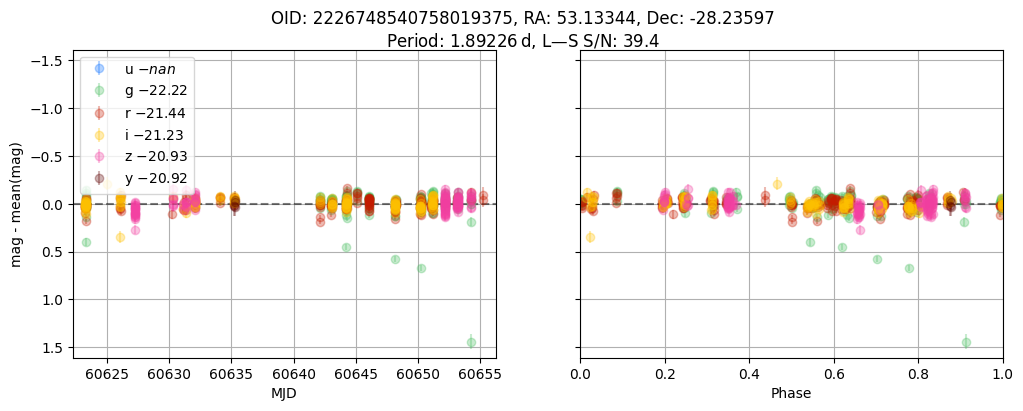

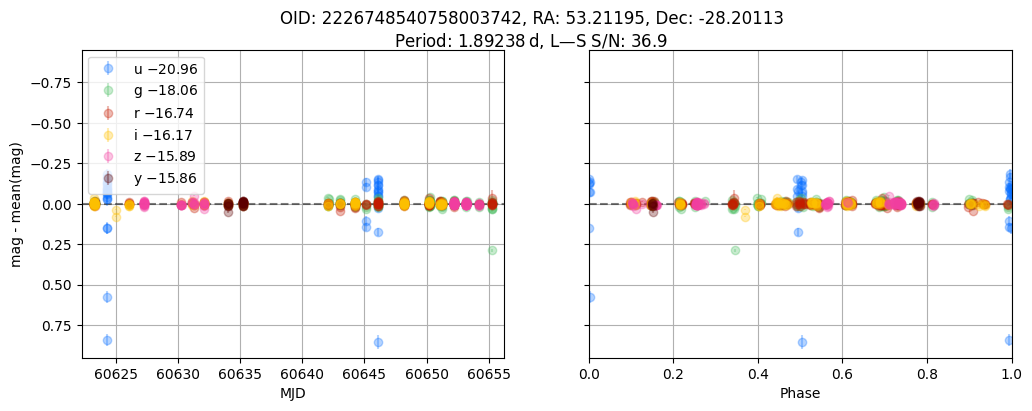

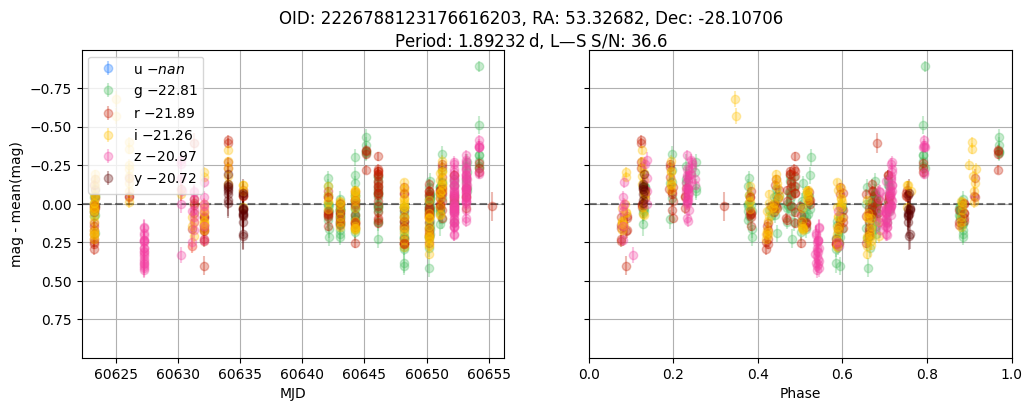

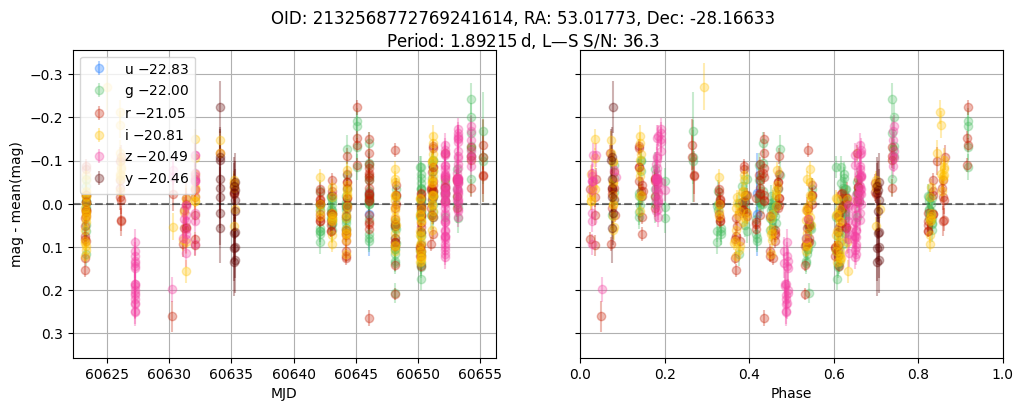

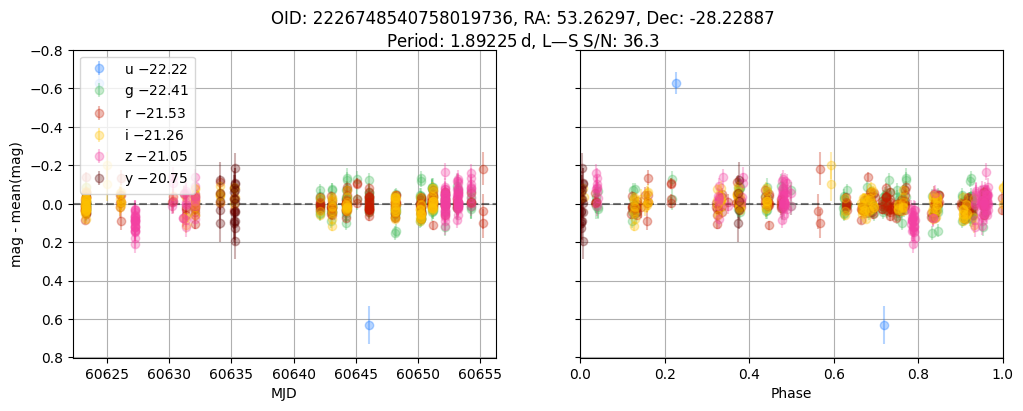

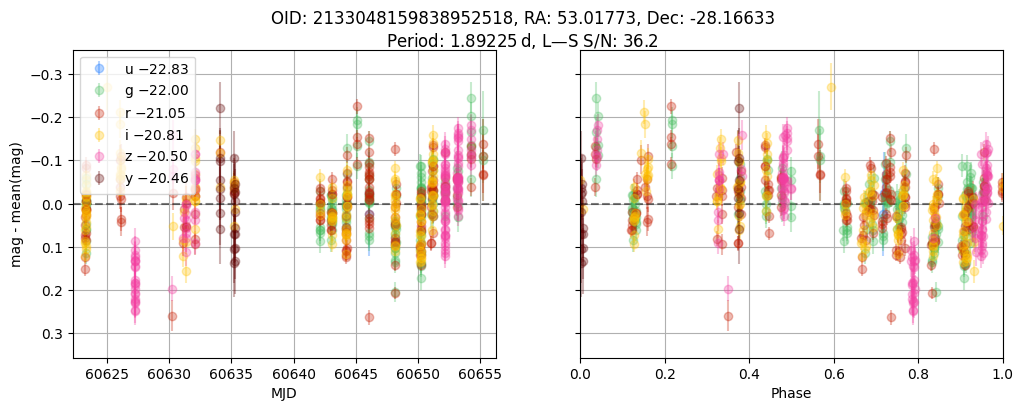

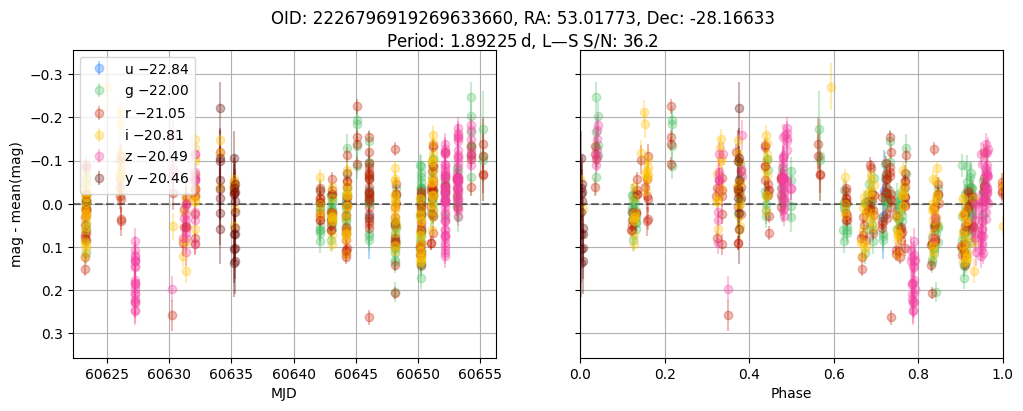

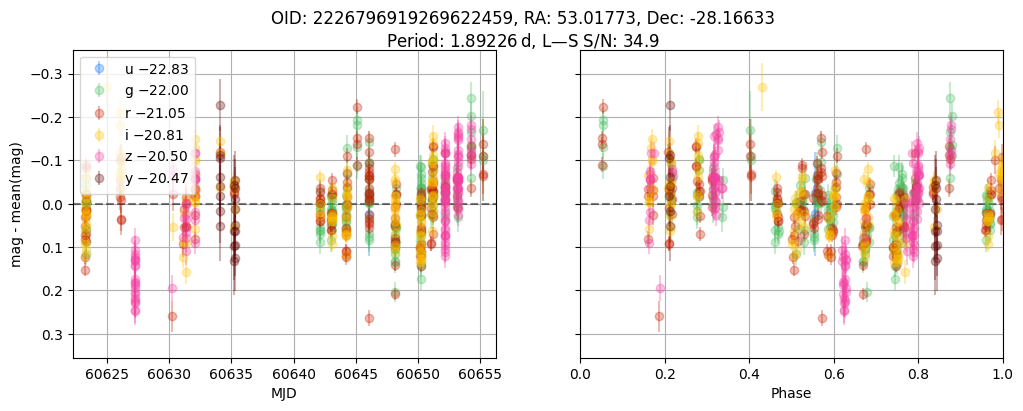

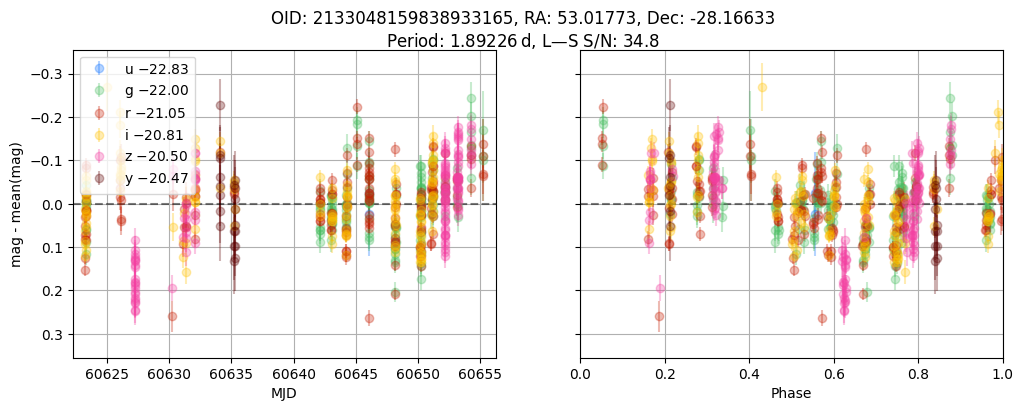

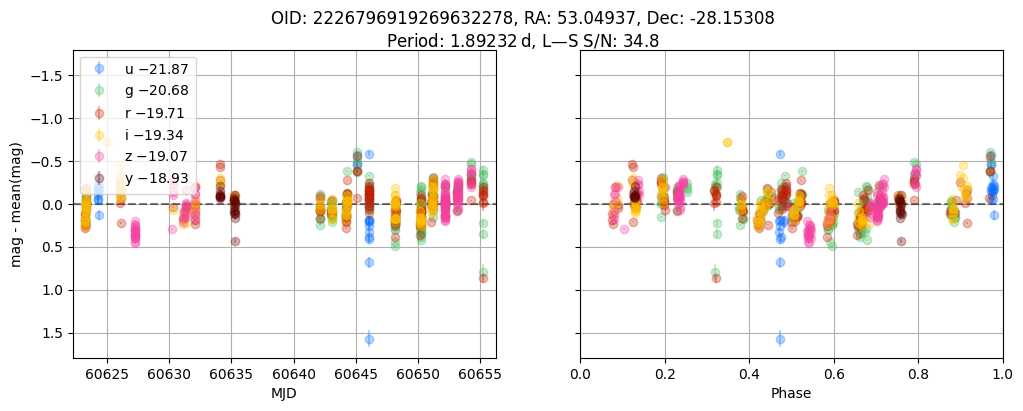

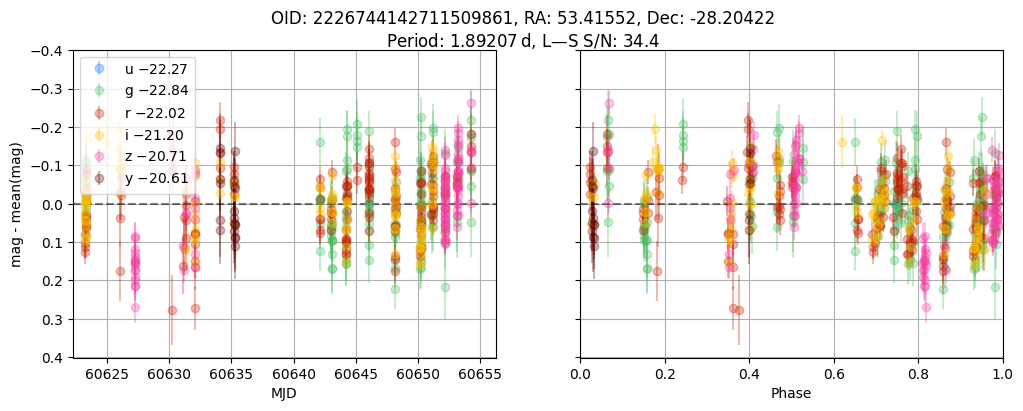

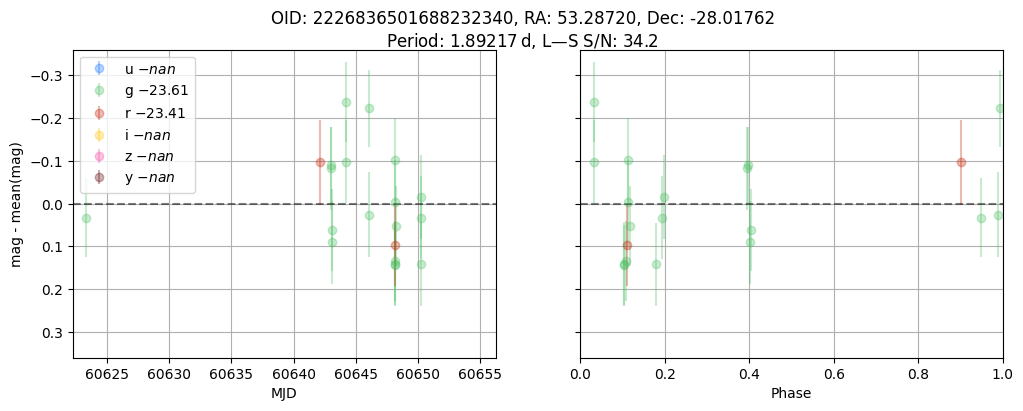

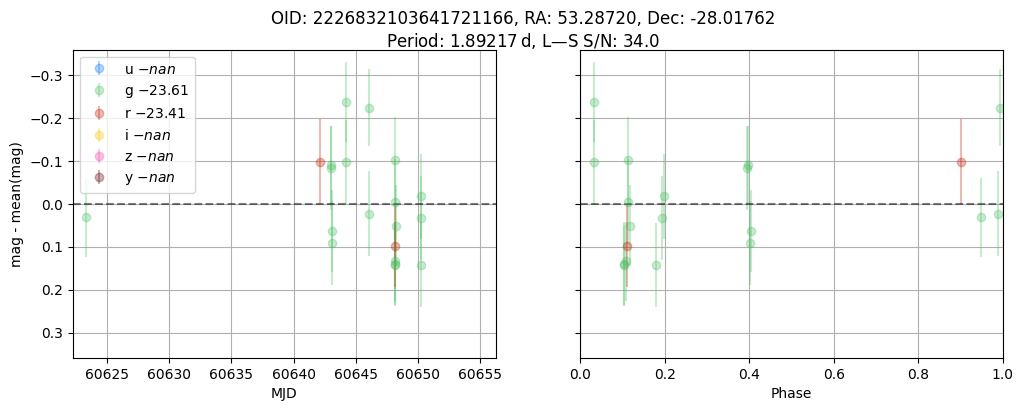

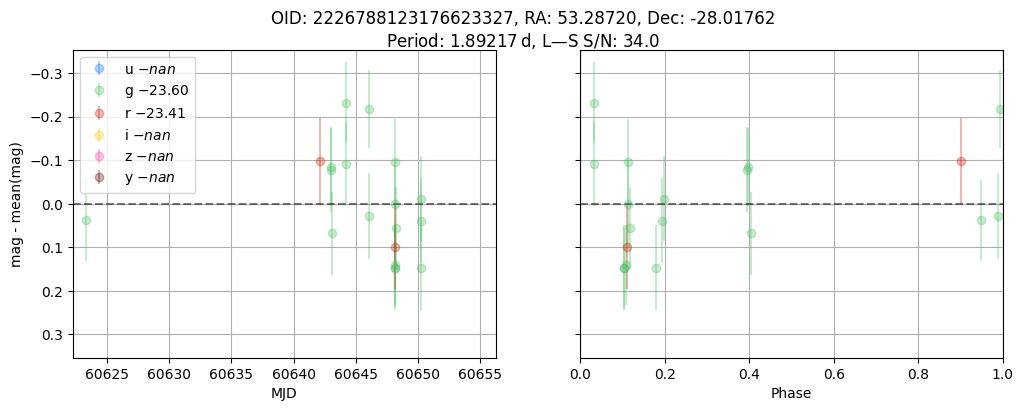

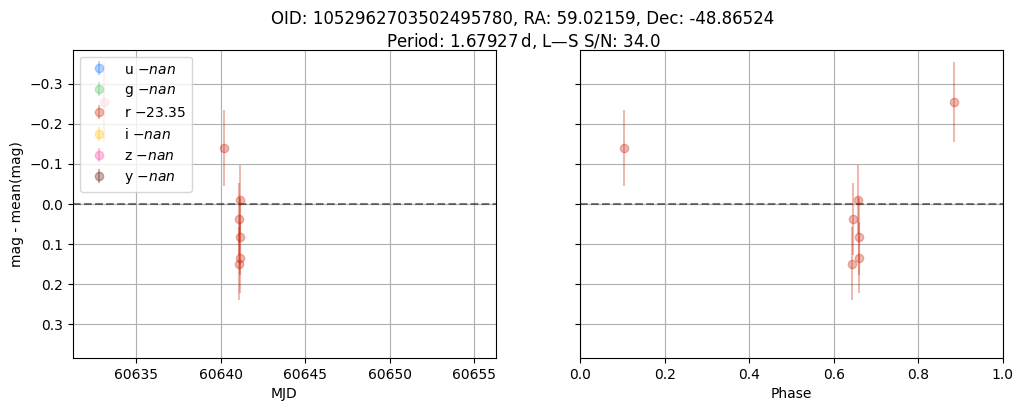

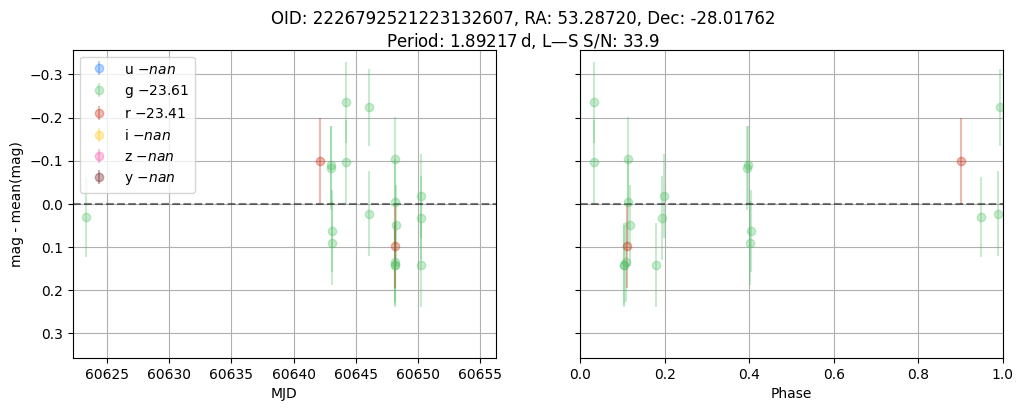

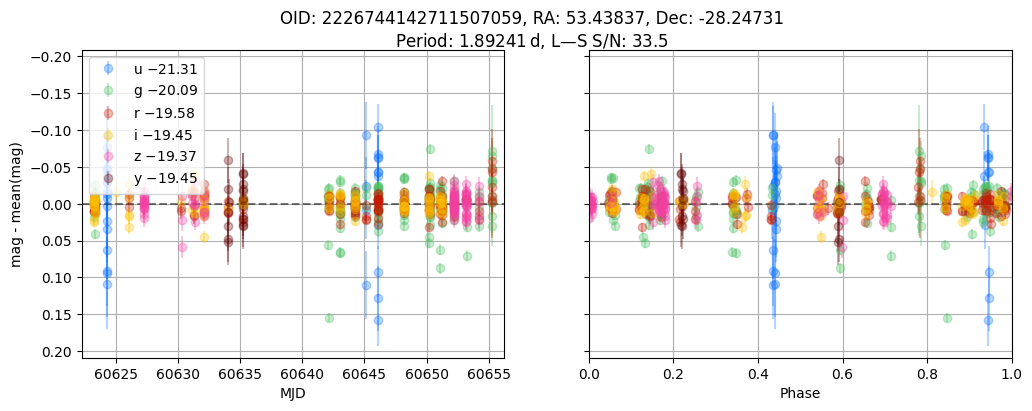

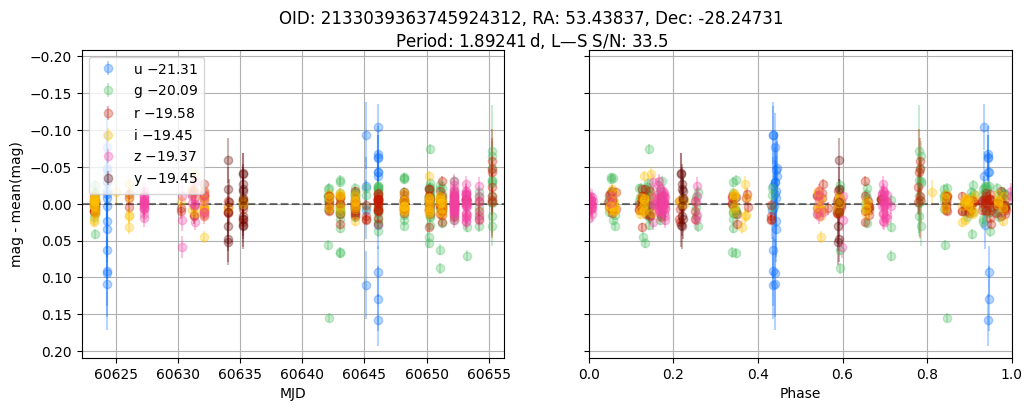

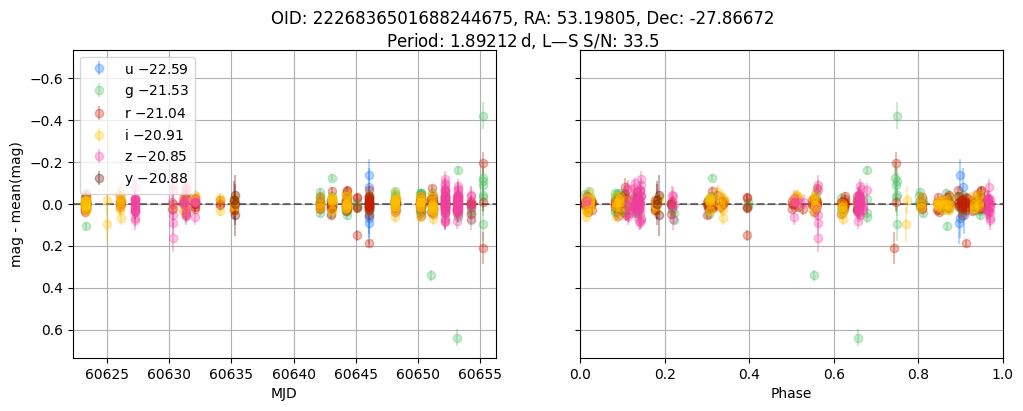

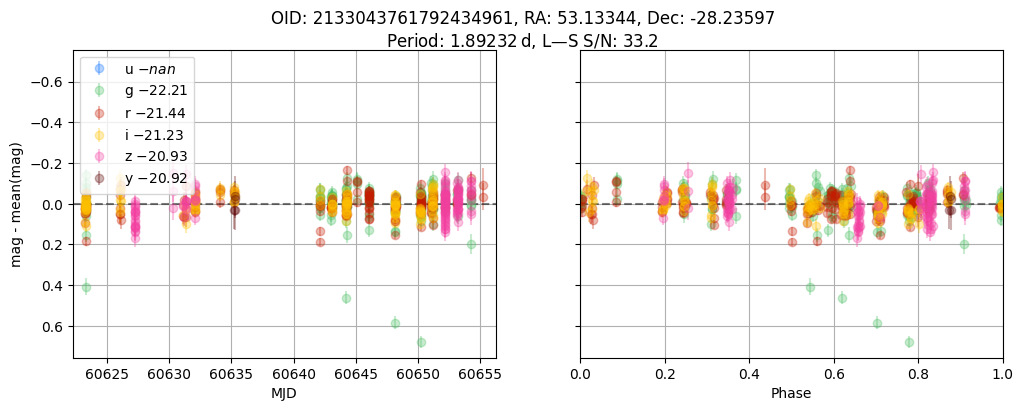

In [13]:
import matplotlib.pyplot as plt

COLORS = {'u': '#0c71ff', 'g': '#49be61', 'r': '#c61c00',
          'i': '#ffc200', 'z': '#f341a2', 'y': '#5d0000'}

FOLDED = True

for healpix29, cand in cand_subset.iloc[:20].iterrows():
    phase = cand.lc["midpointMJDTai"] % cand["period_0"] / cand["period_0"]
    mag = -2.5 * np.log10(cand.lc["psfFlux"]) + 31.4
    magerr = 2.5 / np.log(10) * cand.lc["psfFluxErr"] / cand.lc["psfFlux"]
    fig, (ax_mjd, ax_phase) = plt.subplots(1, 2, figsize=(12, 4), sharey=True)
    for b in BANDS:
        idx = (cand.lc["band"] == b) & (magerr < 0.1)
        mean_band_mag = np.mean(mag[idx])
        errorbar_kwargs = dict(
            y=mag[idx] - mean_band_mag,
            yerr=magerr[idx],
            fmt="o",
            color=COLORS[b],
            label=f'{b} $- {mean_band_mag:.2f}$',
            alpha=0.3,
        )
        ax_mjd.errorbar(cand.lc["midpointMJDTai"][idx], **errorbar_kwargs)
        ax_phase.errorbar(phase[idx], **errorbar_kwargs)
    fig.suptitle(
        f"OID: {cand.objectId}, RA: {cand['coord_ra']:.5f}, Dec: {cand['coord_dec']:.5f}"
        f"\nPeriod: {cand['period_0']:.5f}$\,$d, L—S S/N: {cand['period_s_to_n_0']:.1f}"
    )
    ax_mjd.set_ylabel("mag - mean(mag)")

    ax_mjd.set_xlabel("MJD")
    ax_mjd.set_xlim(np.min(cand.lc["midpointMJDTai"])-1, np.max(cand.lc["midpointMJDTai"])+1)
    ax_phase.set_xlabel("Phase")
    ax_phase.set_xlim(0, 1)
    
    max_abs_ylim = max(np.abs(plt.ylim()))
    plt.ylim(-max_abs_ylim, max_abs_ylim)
    plt.gca().invert_yaxis()
    ax_mjd.plot(ax_mjd.get_xlim(), [0, 0], color='k', linestyle='--', alpha=0.5)
    ax_phase.plot(ax_phase.get_xlim(), [0, 0], color='k', linestyle='--', alpha=0.5)
    ax_mjd.legend(loc='upper left')
    ax_mjd.grid()
    ax_phase.grid()
    
    plt.savefig(f"periodic_cand-{release}-{cand.objectId}.pdf")

    print(cand.objectId)

### Potentially Interesting Candidates
2226748540758018644, 2226840899734749849, 2226796919269630775